In [42]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import ee
import concurrent.futures as cf
import geemap
import os

sns.set_style('whitegrid')
sns.set_palette('Set2')

In [126]:
train_data = pd.read_csv('data/Train.csv', index_col='ID')
test_data = pd.read_csv('data/Test.csv', index_col='ID')

sudan_set = pd.read_csv('data/country/sudan.csv', index_col='ID')
afghanistan_set = pd.read_csv('data/country/afghanistan.csv', index_col='ID')
iran_set = pd.read_csv('data/country/iran.csv', index_col='ID')

countries_set = pd.read_csv('data/country/countries_all_clean.csv', index_col='ID')

In [127]:
countries_set = countries_set.drop(columns=['Lat', 'Lon'])


In [128]:
test_set = countries_set.loc[test_data.index]

In [69]:
# Standardize vrpi column between 0 and 1
countries_set['vrpi'] = (countries_set['vrpi'] - countries_set['vrpi'].min()) / (countries_set['vrpi'].max() - countries_set['vrpi'].min())

array([[<Axes: title={'center': 'B2'}>, <Axes: title={'center': 'B3'}>,
        <Axes: title={'center': 'B4'}>, <Axes: title={'center': 'B5'}>],
       [<Axes: title={'center': 'B6'}>, <Axes: title={'center': 'B7'}>,
        <Axes: title={'center': 'B8'}>, <Axes: title={'center': 'B8A'}>],
       [<Axes: title={'center': 'B11'}>, <Axes: title={'center': 'B12'}>,
        <Axes: title={'center': 'ndvi'}>,
        <Axes: title={'center': 'ndwi'}>],
       [<Axes: title={'center': 'evi'}>,
        <Axes: title={'center': 'savi'}>,
        <Axes: title={'center': 'gndvi'}>,
        <Axes: title={'center': 'msavi2'}>],
       [<Axes: title={'center': 'pvi'}>,
        <Axes: title={'center': 'vrpi'}>, <Axes: >, <Axes: >]],
      dtype=object)

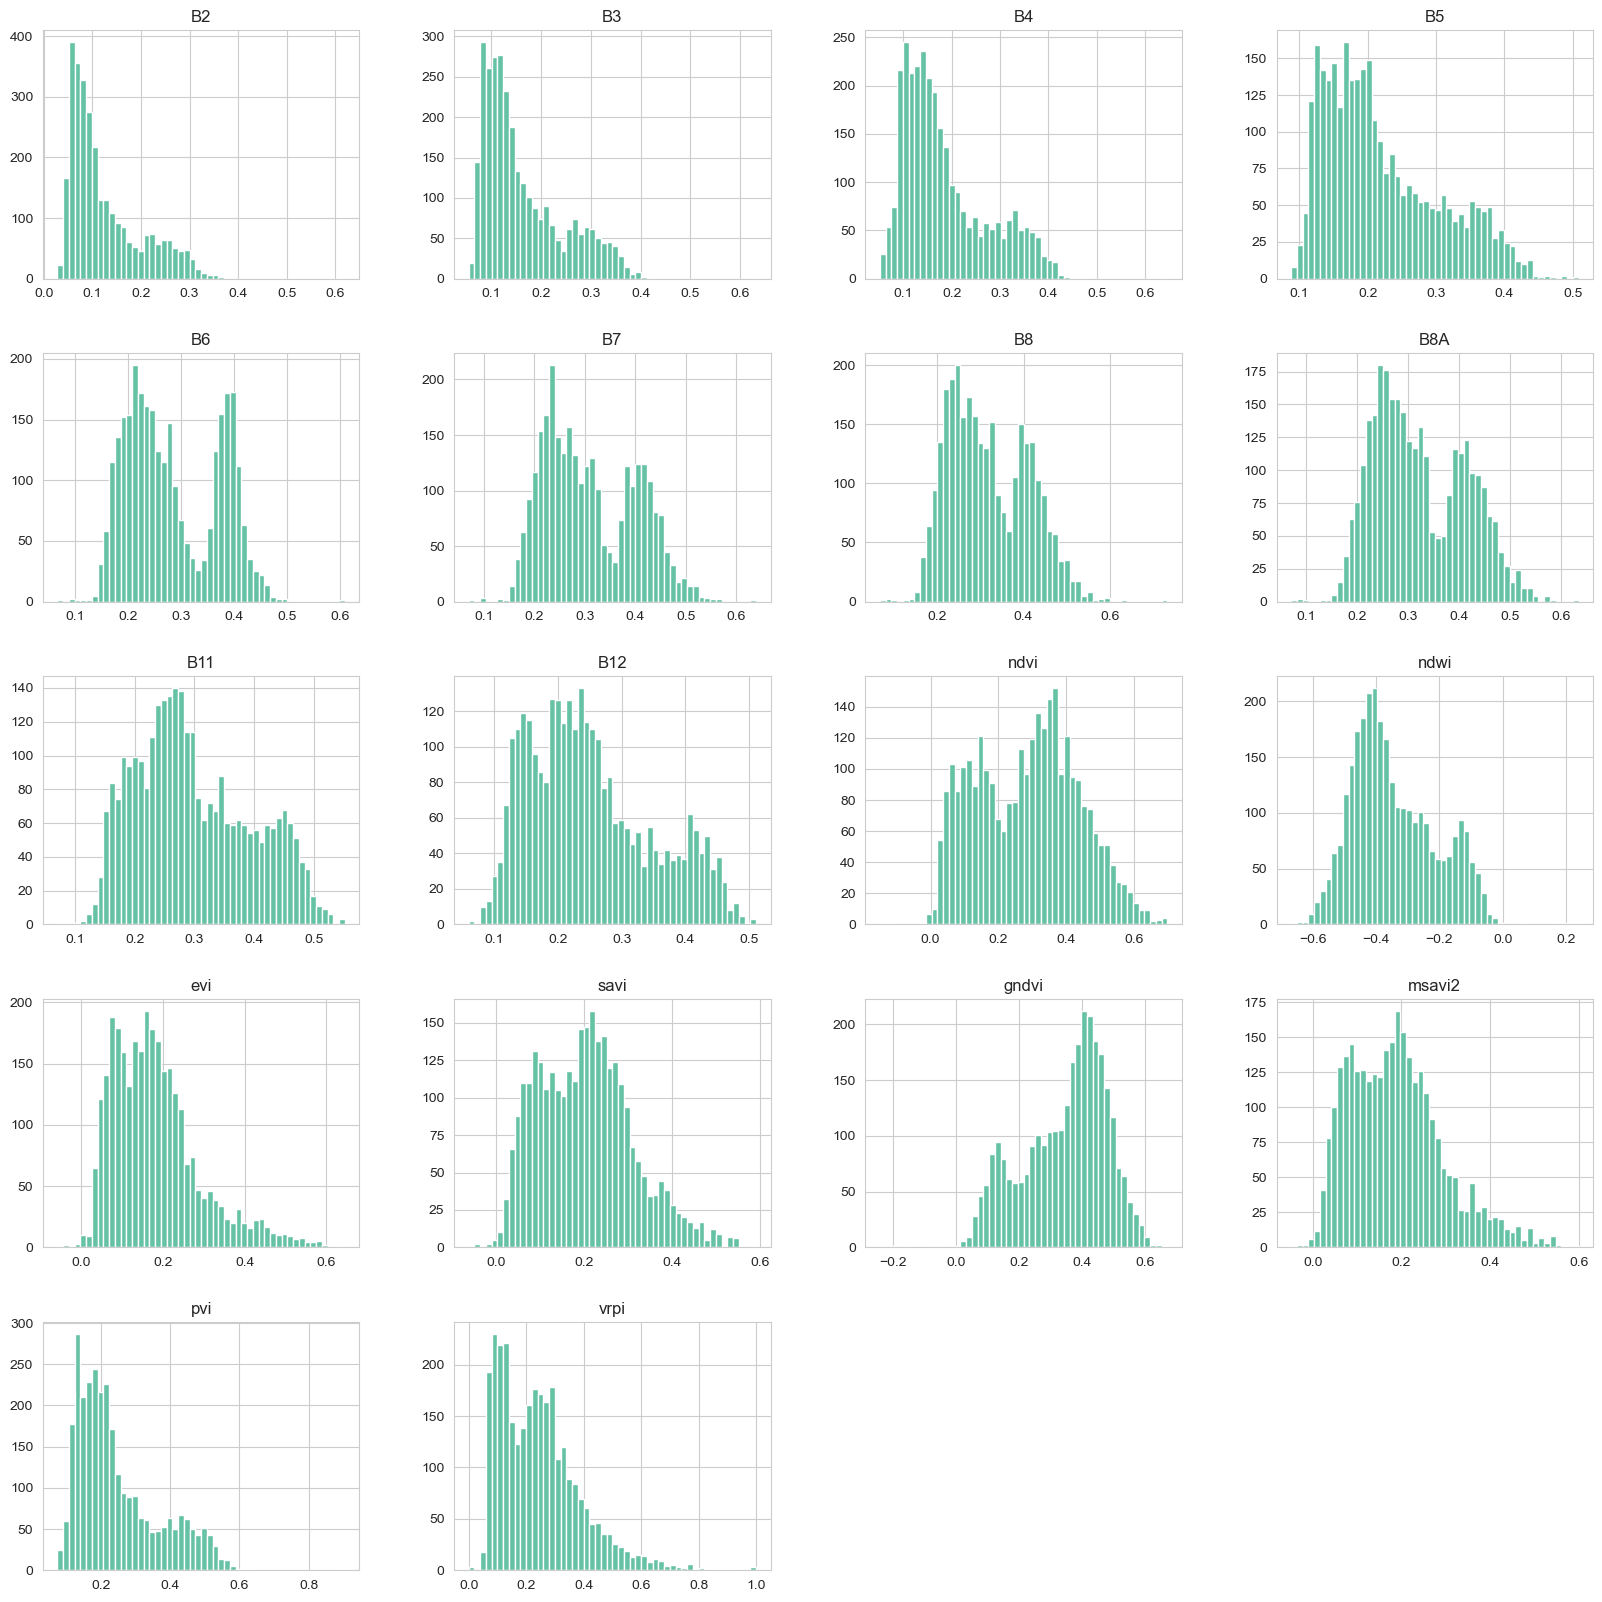

In [70]:
countries_set.hist(figsize=(20, 20), bins=50)

<Axes: >

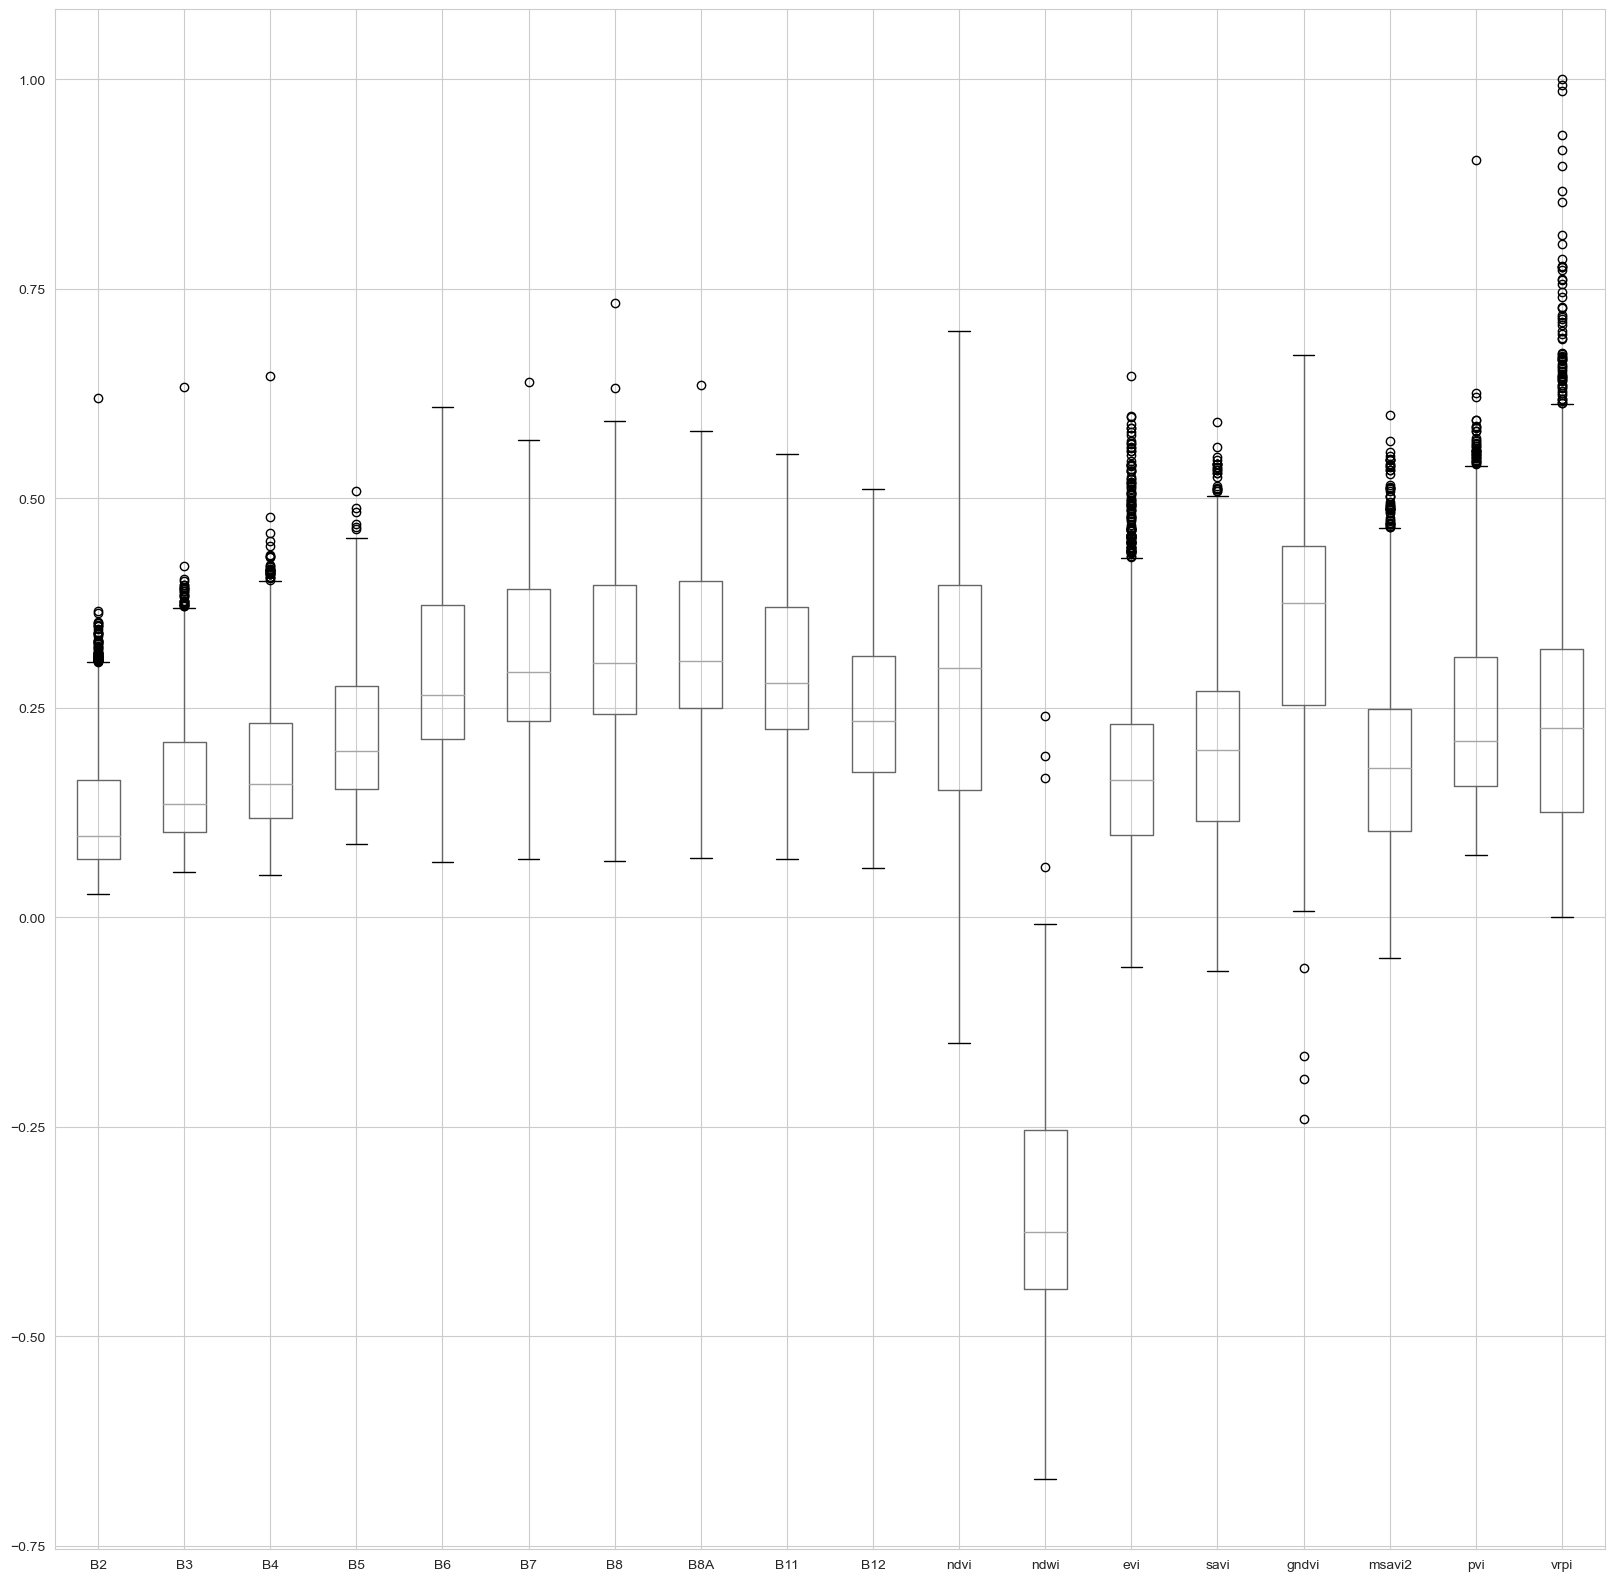

In [71]:
# Boxplot for all the features
plt.figure(figsize=(20, 20))
countries_set.boxplot()


In [59]:
# remove outliers
def remove_outliers(df, columns):
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        df = df[(df[column] >= q1 - 1.5 * iqr) & (df[column] <= q3 + 1.5 * iqr)]
    return df

<Axes: >

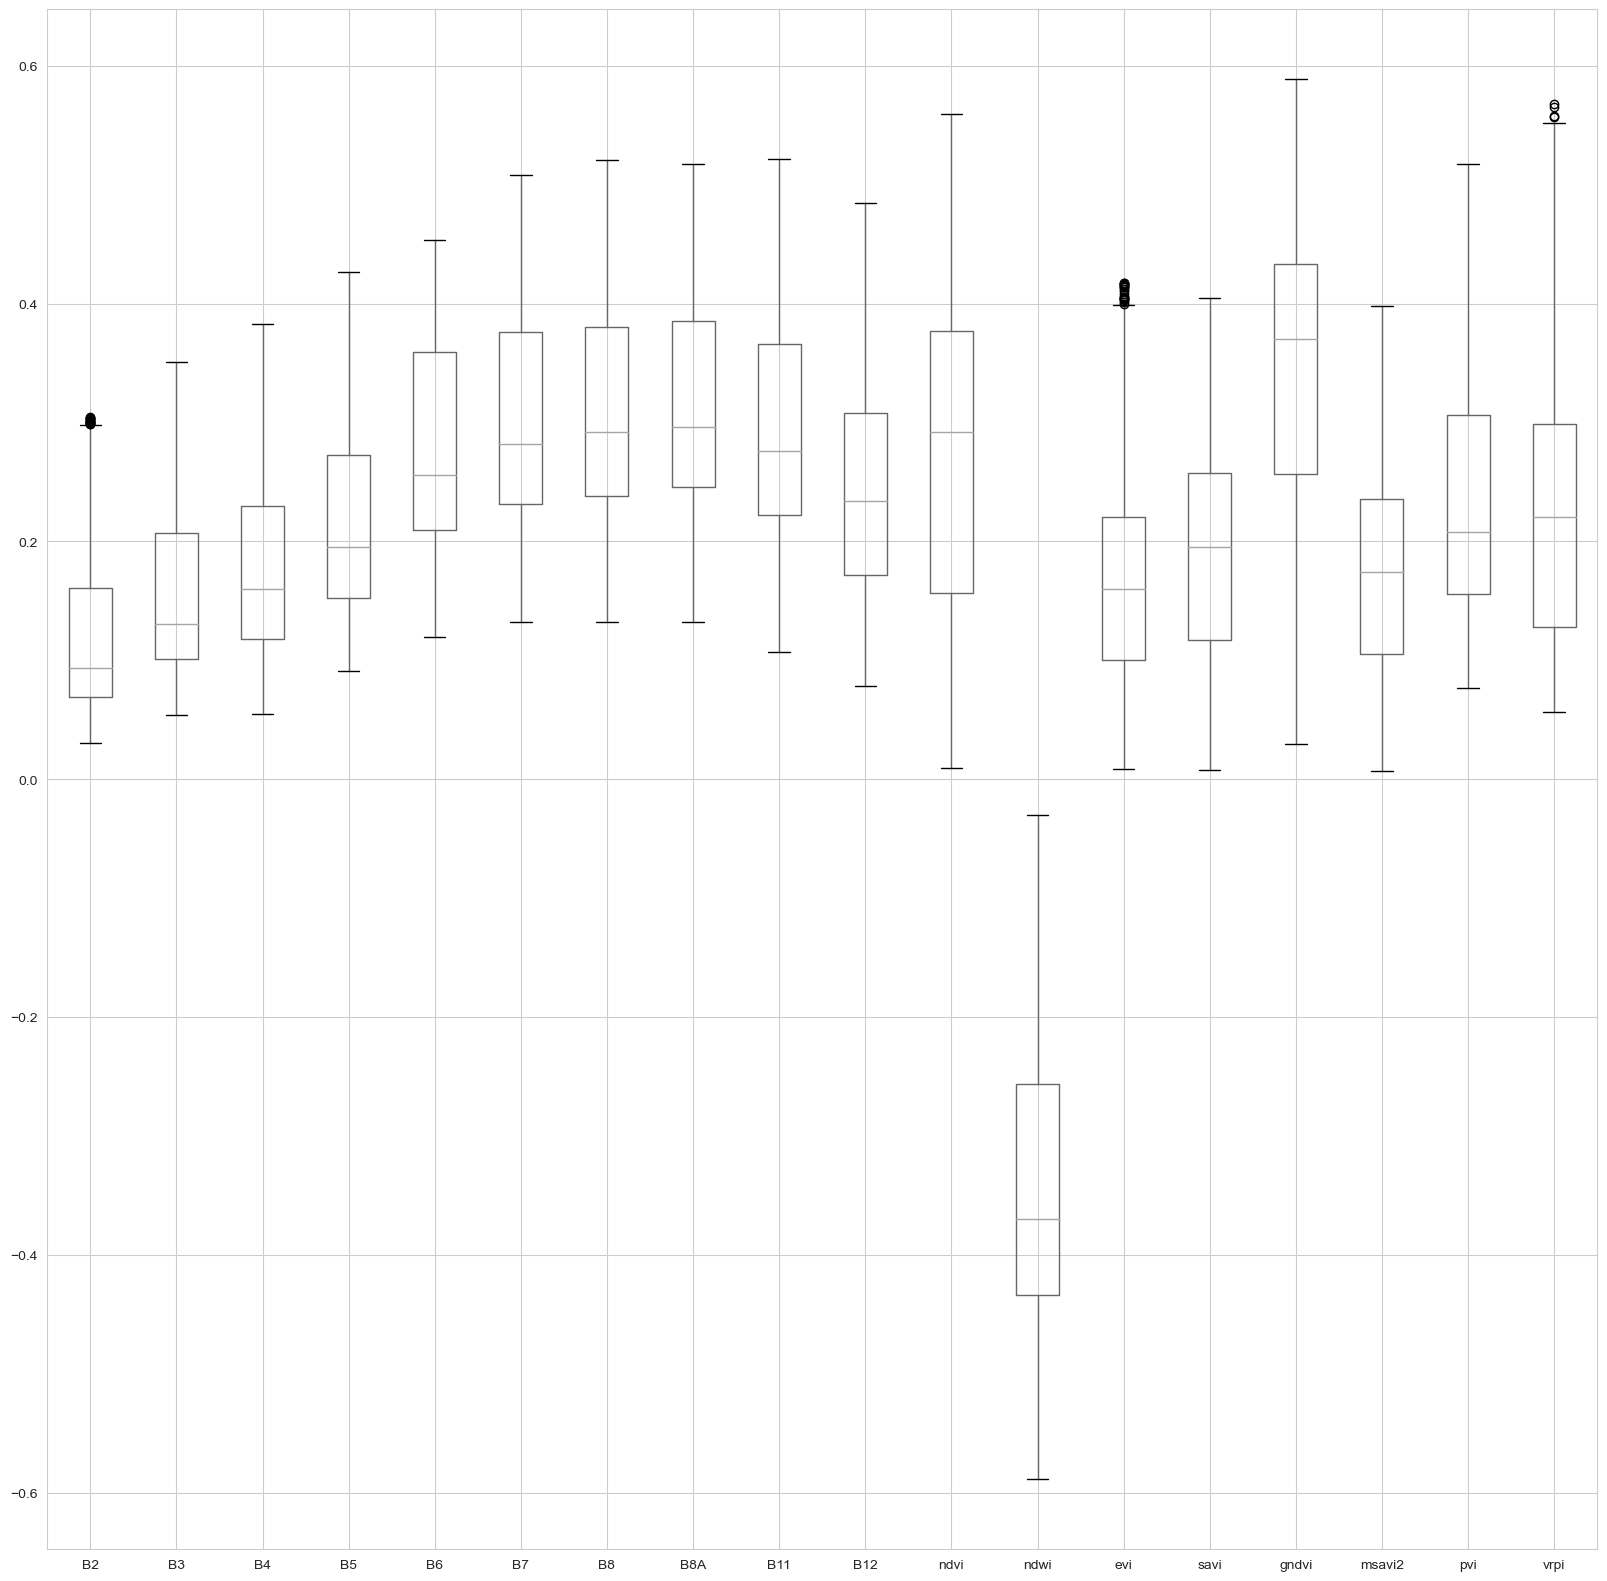

In [74]:
country_set_adj = remove_outliers(countries_set, columns=['B2','B3','B4','B5', 'ndwi','gndvi','msavi2','pvi', 'evi', 'vrpi'])
country_set_adj.boxplot(figsize=(20, 20))

<Axes: >

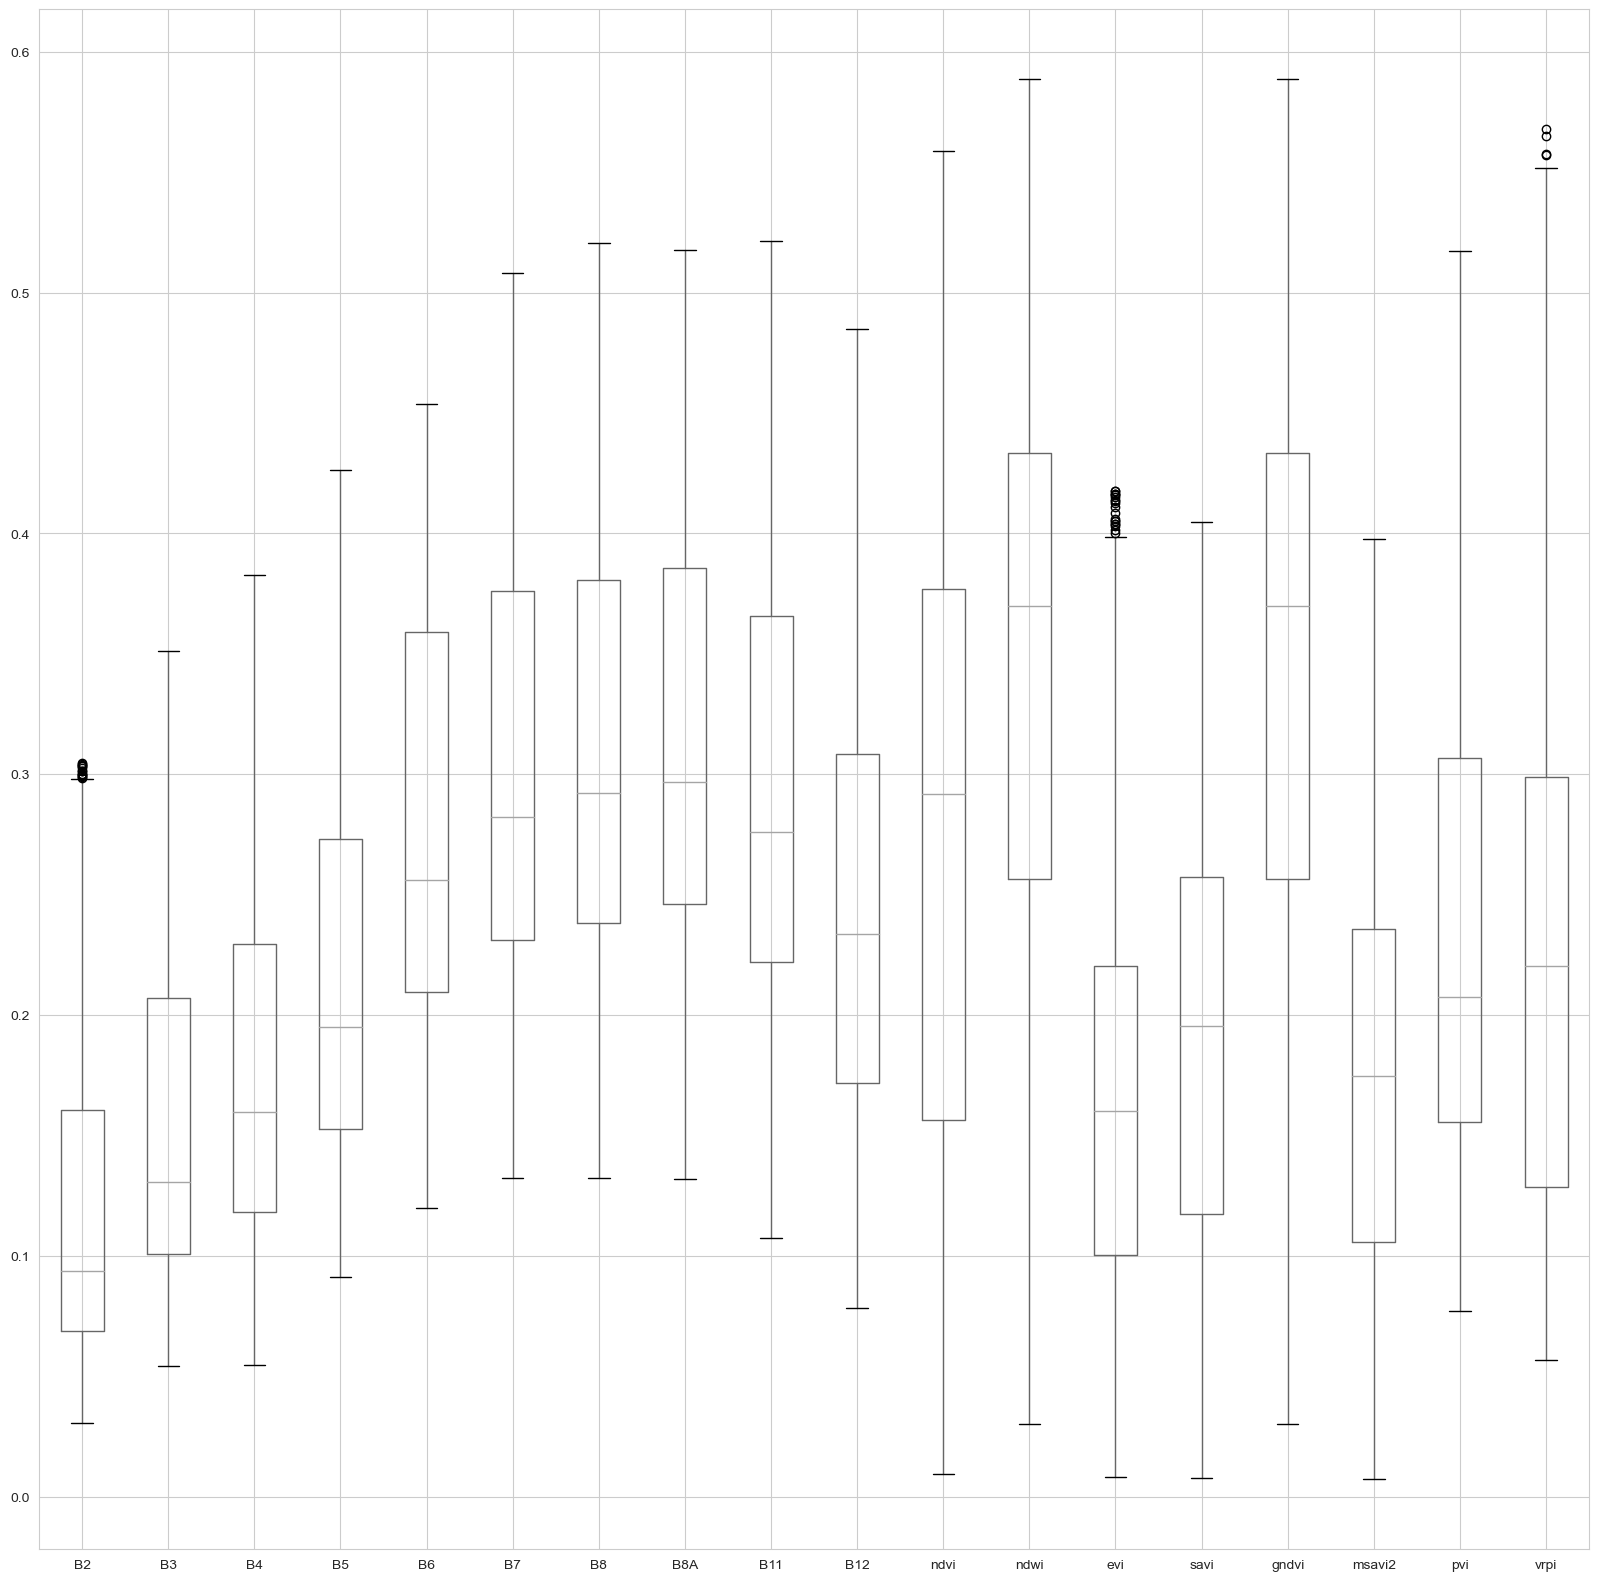

In [76]:
# make ndwi absolute
country_set_adj['ndwi'] = country_set_adj['ndwi'].abs()
country_set_adj.boxplot(figsize=(20, 20))

In [110]:
train_adj = country_set_adj.join(train_data, how='inner')
train_adj

,Country,B2,B3,B4,B5,B6,B7,B8,B8A,B11,...,ndwi,evi,savi,gndvi,msavi2,pvi,vrpi,Lat,Lon,Target
ID,,,,,,,,,,,,,,,,,,,,,
ID_CWCD60FGJJYY,Iran,0.063594,0.090949,0.098181,0.133774,0.211879,0.236113,0.263564,0.259492,0.209702,...,0.486907,0.240435,0.287875,0.486907,0.261305,0.133833,0.395170,32.075695,48.492047,0
ID_5QV3RGD8E6L6,Iran,0.086345,0.121840,0.137183,0.187053,0.284357,0.315555,0.328977,0.327260,0.273866,...,0.459468,0.254962,0.297767,0.459468,0.277964,0.183478,0.336987,32.309077,48.324152,1
ID_OGEL0LA7Y94S,Iran,0.064592,0.086646,0.089351,0.118080,0.169262,0.186600,0.204797,0.199114,0.184553,...,0.405399,0.183764,0.218057,0.405399,0.189194,0.124463,0.315446,32.294165,48.176020,0
ID_O4CHBAKY74WZ,Iran,0.071220,0.102044,0.120701,0.150555,0.230503,0.270276,0.281481,0.286482,0.256352,...,0.467864,0.218520,0.267318,0.467864,0.243752,0.158056,0.323571,32.379146,48.215546,1
ID_7VVCEG83E9SF,Iran,0.051547,0.076480,0.079600,0.122210,0.193281,0.219104,0.226569,0.239260,0.190269,...,0.495264,0.223092,0.273458,0.495264,0.242870,0.110387,0.428057,32.110459,48.207102,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_E7NRE7KYJSYG,Sudan,0.058676,0.091763,0.124826,0.184793,0.217561,0.241028,0.252430,0.269615,0.339883,...,0.466794,0.163457,0.218188,0.466794,0.194808,0.154926,0.260633,14.514619,33.547944,0
ID_RZT2LG5XUKPT,Sudan,0.071247,0.101594,0.127062,0.155162,0.201791,0.230823,0.244191,0.245457,0.203840,...,0.412389,0.159121,0.201657,0.412389,0.178894,0.162684,0.240231,14.297676,33.332887,1
ID_OJB81QF7T0BJ,Sudan,0.125519,0.161429,0.189887,0.215237,0.242996,0.259125,0.267612,0.269815,0.245169,...,0.247490,0.106070,0.121762,0.247490,0.108994,0.249232,0.136107,14.195807,33.383462,0


In [116]:
train_set = train_adj.drop(columns=['Target','Lat','Lon'])
train_set = pd.get_dummies(train_set, columns=['Country'])
target = train_adj['Target']

In [117]:
train_set.shape
# target.shape

(1354, 21)

In [104]:
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.preprocessing import StandardScaler

def feature_selection(X, y, k=18):
    selector = SelectKBest(f_classif, k=k)
    selector.fit(X, y)
    cols = selector.get_support(indices=True)
    X_new = X.iloc[:, cols]
    return X_new


In [105]:
def feature_selection_variance(X, threshold=0.1):
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X)
    cols = selector.get_support(indices=True)
    X_new = X.iloc[:, cols]
    return X_new

In [87]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [118]:
X_train, X_test, y_train, y_test = train_test_split(train_set, target, test_size=0.3, random_state=300)

In [119]:
X_train

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,...,ndwi,evi,savi,gndvi,msavi2,pvi,vrpi,Country_Afghanistan,Country_Iran,Country_Sudan
ID,,,,,,,,,,,,,,,,,,,,,
ID_RZT2LG5XUKPT,0.071247,0.101594,0.127062,0.155162,0.201791,0.230823,0.244191,0.245457,0.203840,0.153785,...,0.412389,0.159121,0.201657,0.412389,0.178894,0.162684,0.240231,False,False,True
ID_J5TCS8OYE8WL,0.064363,0.095500,0.118225,0.174406,0.214758,0.233869,0.241725,0.245554,0.244092,0.212329,...,0.433613,0.168215,0.215419,0.433613,0.191129,0.151978,0.265176,False,False,True
ID_8VNTHGHLSUNI,0.070671,0.110467,0.161225,0.200179,0.231804,0.248965,0.250033,0.259077,0.298663,0.268846,...,0.387147,0.105264,0.146185,0.387147,0.129603,0.195439,0.164857,False,False,True
ID_EJ315KRK6NXM,0.224125,0.271000,0.303000,0.346975,0.389175,0.414375,0.400400,0.419050,0.439650,0.402125,...,0.192732,0.126702,0.121406,0.192732,0.115594,0.406510,0.118255,True,False,False
ID_AI34GRUGG83I,0.119095,0.156318,0.192972,0.213603,0.232139,0.244261,0.241619,0.252302,0.281858,0.261081,...,0.214358,0.064594,0.078078,0.214358,0.068786,0.248342,0.104165,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_GQZCJ8BDY4N5,0.049279,0.075213,0.085176,0.114383,0.188919,0.224854,0.237143,0.236980,0.162524,0.124910,...,0.518417,0.220464,0.277204,0.518417,0.247810,0.113630,0.415420,False,False,True
ID_U383CJ7LI2U8,0.080345,0.121245,0.156073,0.190663,0.243312,0.266196,0.276980,0.287559,0.252053,0.184700,...,0.391073,0.150116,0.194372,0.391073,0.175411,0.197634,0.210333,False,False,True
ID_5GS054Q9NS64,0.048150,0.080673,0.086579,0.152454,0.250435,0.282410,0.291567,0.300598,0.238035,0.166331,...,0.566554,0.282758,0.350148,0.566554,0.326161,0.118339,0.533962,False,False,True


In [120]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_best_params = {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50}

gbc_model = GradientBoostingClassifier(**gbc_best_params)
gbc_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, min_samples_split=3,
                           n_estimators=50)

In [121]:
gbc_model.score(X_test, y_test)
gbc_pred = gbc_model.predict(X_test)
print(classification_report(y_test, gbc_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       224
           1       0.80      0.85      0.82       183

    accuracy                           0.84       407
   macro avg       0.83      0.84      0.83       407
weighted avg       0.84      0.84      0.84       407



In [131]:
test_set = pd.get_dummies(test_set, columns=['Country'])

In [132]:
test_set.shape

(1500, 21)

In [ ]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [133]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_best_params = {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50}

gbc_model = GradientBoostingClassifier(**gbc_best_params)
gbc_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, min_samples_split=3,
                           n_estimators=50)

In [134]:
gbc_model.score(X_test, y_test)
gbc_pred = gbc_model.predict(X_test)
print(classification_report(y_test, gbc_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       224
           1       0.80      0.85      0.83       183

    accuracy                           0.84       407
   macro avg       0.84      0.84      0.84       407
weighted avg       0.84      0.84      0.84       407



In [138]:
feature_weights = pd.DataFrame({'feature': X_train.columns, 'weight': gbc_model.feature_importances_})
feature_weights.sort_values(by='weight', ascending=False, inplace=True)
feature_weights.head(25)

,feature,weight
10,ndvi,0.121641
2,B4,0.120427
8,B11,0.110637
17,vrpi,0.096334
9,B12,0.077334
15,msavi2,0.057707
6,B8,0.048744
0,B2,0.043543
5,B7,0.043466
3,B5,0.042698


In [136]:
best_xgb_params = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'min_child_weight': 5,
    'gamma': 0.1,
    'reg_alpha': 0.01,
    'reg_lambda': 0.1,
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss'         # Evaluation metric for binary classification
}

xgb_class = XGBClassifier(**best_xgb_params)
xgb_class.fit(X_train, y_train)
y_pred = xgb_class.predict(X_test)
accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       224
           1       0.79      0.86      0.83       183

    accuracy                           0.84       407
   macro avg       0.83      0.84      0.83       407
weighted avg       0.84      0.84      0.84       407



In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Load a sample dataset (you can replace this with your own dataset)
data = load_breast_cancer()
X, y = data.data, data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Train a Gradient Boosting model to get feature importances
gbm = GradientBoostingClassifier()
gbm.fit(X_train, y_train)

# Get feature importances (weights) from the trained model
feature_importances = gbm.feature_importances_

# Step 2: Scale the feature importances to the range [0, 1]
scaled_weights = (feature_importances - feature_importances.min()) / (feature_importances.max() - feature_importances.min())

# Step 3: Create a custom objective function in XGBoost with scaled weights
def custom_obj(y_pred, dtrain):
    y_true = dtrain.get_label()
    grad = y_pred - y_true  # Calculate gradient
    hess = np.ones_like(grad)  # Constant hessian for binary classification
    # Apply scaled weights to gradient
    grad *= scaled_weights
    return grad, hess

# Step 4: Train an XGBoost model with the custom objective function
params = {
    'objective': custom_obj,  # Use the custom objective function
    'eval_metric': 'logloss',  # You can choose an appropriate evaluation metric
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'random_state': 42,
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

xgb_model = xgb.train(params, dtrain, num_boost_round=params['n_estimators'], evals=[(dtest, 'test')])

# Evaluate the XGBoost model
predictions = xgb_model.predict(dtest)
accuracy = np.mean((predictions > 0.5) == y_test)
print(f"Accuracy of the XGBoost model with scaled feature weights: {accuracy:.2f}")
